### Import the libraries, load dataset, print shape of data, data description

In [49]:
# Importing the libraries
import re , unicodedata, string
import numpy as np                                  #for large and multi-dimensional arrays
import pandas as pd                                 #for data manipulation and analysis
import nltk                                         #Natural language processing tool-kit
!pip install contractions

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import contractions 
from nltk.corpus import stopwords                   #Stopwords corpus
from nltk.stem import PorterStemmer                 # Stemmer
from nltk.tokenize import word_tokenize 

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer          #For TF-IDF
from google.colab import drive
from bs4 import BeautifulSoup

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
from nltk.stem.wordnet import WordNetLemmatizer 

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [50]:
# Loading Data
drive.mount('/content/drive')    
tweets = pd.read_csv("/content/drive/My Drive/NLP/Tweets.csv")#, header=0,delimiter="\t", quoting=3)
tweets.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [51]:
# Printing Shape of Data
tweets.shape

(14640, 15)

In [52]:
# Data Description
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

### Understand of data-columns

In [53]:
pd.set_option('display.max_colwidth', None)

In [54]:
# Drop all columns except "text" & "airline sentiment"
tweets2=tweets[['airline_sentiment','text']].copy()


In [55]:
# Shape of Data after dropping
tweets2.shape

(14640, 2)

In [56]:
# Printing first 5 rows of the new DataSet
tweets2.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


In [57]:
# Printing the info of the dataframe
tweets2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14640 non-null  object
 1   text               14640 non-null  object
dtypes: object(2)
memory usage: 228.9+ KB


Observation: Both columns are of type "object"


#### Observations: The new dataset has no nulls.

In [58]:
# Printing the value counts of the Airline Sentiments
tweets2['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [59]:
# Mapping Sentiments text to Numbers
mapping={'negative':0,'neutral':1,'positive':2}
tweets2['airline_sentiment']=tweets2['airline_sentiment'].replace(mapping)
tweets2.head()

,airline_sentiment,text
0,1,@VirginAmerica What @dhepburn said.
1,2,@VirginAmerica plus you've added commercials to the experience... tacky.
2,1,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,0,@VirginAmerica and it's a really big bad thing about it


### Text pre-processing:

In [60]:
tweets2.head(10)

,airline_sentiment,text
0,1,@VirginAmerica What @dhepburn said.
1,2,@VirginAmerica plus you've added commercials to the experience... tacky.
2,1,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,0,@VirginAmerica and it's a really big bad thing about it
5,0,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA
6,2,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)"
7,1,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP"
8,2,"@virginamerica Well, I didn't…but NOW I DO! :-D"
9,2,"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me."


In [61]:
# Printing Stop words and removing custom list from it
print (stopwords.words("english")) 
stopwords = stopwords.words('english')
customlist = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't",'no','nor']

# Set custom stop-word's list as not, couldn't etc. words matter in Sentiment, so not removing them from original data.

stopwords = list(set(stopwords) - set(customlist))
# Appending words in stoplist
stopwords.append('shall');stopwords.append('must');stopwords.append('could')
stopwords.append('might');stopwords.append('need')     

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [62]:
# Working to check the stoplist is working on customlist
custom=""
for w in customlist:
  #print(w)
  if w not in stopwords:
    #new_words.append(w)
    custom=custom+' '+w
    #new_words1=' '.join(w)
print("wordstr--",custom)
new_custom=contractions.fix(custom)
print("wordstr--",new_custom)
wordstr=""
tokens = word_tokenize(new_custom)
for w in tokens:
  if w not in stopwords:
    wordstr=wordstr+' '+w
print(wordstr)

wordstr--  not couldn't didn didn't doesn doesn't hadn hadn't hasn hasn't haven haven't isn isn't ma mightn mightn't mustn mustn't needn needn't shan shan't shouldn shouldn't wasn wasn't weren weren't won won't wouldn wouldn't no nor
wordstr--  not could not didn did not doesn does not hadn had not hasn has not haven have not isn is not ma mightn might not mustn must not needn need not shan shall not shouldn should not wasn was not weren were not won will not wouldn would not no nor
 not not didn not doesn not hadn not hasn not haven not isn not ma mightn not mustn not needn not shan not shouldn not wasn not weren not won not wouldn would not no nor


In [63]:
### Removing HTML Tags
def remove_html(text):
    html_remove = BeautifulSoup(text, "html.parser").get_text() 
    return html_remove

tweets2["text"] = tweets2["text"].apply(lambda x: remove_html(x))
tweets2.head(10)

,airline_sentiment,text
0,1,@VirginAmerica What @dhepburn said.
1,2,@VirginAmerica plus you've added commercials to the experience... tacky.
2,1,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,0,@VirginAmerica and it's a really big bad thing about it
5,0,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA
6,2,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)"
7,1,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP"
8,2,"@virginamerica Well, I didn't…but NOW I DO! :-D"
9,2,"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me."


In [64]:
### Replace contractions in string
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

tweets2["text"] = tweets2["text"].apply(lambda x: replace_contractions(x))
tweets2.head(10)

,airline_sentiment,text
0,1,@VirginAmerica What @dhepburn said.
1,2,@VirginAmerica plus you have added commercials to the experience... tacky.
2,1,@VirginAmerica I did not today... Must mean I need to take another trip!
3,0,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,0,@VirginAmerica and it is a really big bad thing about it
5,0,@VirginAmerica seriously would pay $30 a flight for seats that did not have this playing.\nit is really the only bad thing about flying VA
6,2,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” will not go away :)"
7,1,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP"
8,2,"@virginamerica Well, I did not…but NOW I DO! :-D"
9,2,"@VirginAmerica it was amazing, and arrived an hour early. you are too good to me."


In [65]:
## Remove the numbers
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

tweets2["text"] = tweets2["text"].apply(lambda x: remove_numbers(x))
tweets2.head(10)

,airline_sentiment,text
0,1,@VirginAmerica What @dhepburn said.
1,2,@VirginAmerica plus you have added commercials to the experience... tacky.
2,1,@VirginAmerica I did not today... Must mean I need to take another trip!
3,0,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,0,@VirginAmerica and it is a really big bad thing about it
5,0,@VirginAmerica seriously would pay $ a flight for seats that did not have this playing.\nit is really the only bad thing about flying VA
6,2,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” will not go away :)"
7,1,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpGgrEZP"
8,2,"@virginamerica Well, I did not…but NOW I DO! :-D"
9,2,"@VirginAmerica it was amazing, and arrived an hour early. you are too good to me."


In [66]:
### Tokenization
tweets2["text"] = tweets2["text"].apply(lambda row: nltk.word_tokenize(row)) # Tokenization of data
tweets2.head()

,airline_sentiment,text
0,1,"[@, VirginAmerica, What, @, dhepburn, said, .]"
1,2,"[@, VirginAmerica, plus, you, have, added, commercials, to, the, experience, ..., tacky, .]"
2,1,"[@, VirginAmerica, I, did, not, today, ..., Must, mean, I, need, to, take, another, trip, !]"
3,0,"[@, VirginAmerica, it, is, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, they, have, little, recourse]"
4,0,"[@, VirginAmerica, and, it, is, a, really, big, bad, thing, about, it]"


In [67]:
tweets2.head(10)

,airline_sentiment,text
0,1,"[@, VirginAmerica, What, @, dhepburn, said, .]"
1,2,"[@, VirginAmerica, plus, you, have, added, commercials, to, the, experience, ..., tacky, .]"
2,1,"[@, VirginAmerica, I, did, not, today, ..., Must, mean, I, need, to, take, another, trip, !]"
3,0,"[@, VirginAmerica, it, is, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, they, have, little, recourse]"
4,0,"[@, VirginAmerica, and, it, is, a, really, big, bad, thing, about, it]"
5,0,"[@, VirginAmerica, seriously, would, pay, $, a, flight, for, seats, that, did, not, have, this, playing, ., it, is, really, the, only, bad, thing, about, flying, VA]"
6,2,"[@, VirginAmerica, yes, ,, nearly, every, time, I, fly, VX, this, “, ear, worm, ”, will, not, go, away, :, )]"
7,1,"[@, VirginAmerica, Really, missed, a, prime, opportunity, for, Men, Without, Hats, parody, ,, there, ., https, :, //t.co/mWpGgrEZP]"
8,2,"[@, virginamerica, Well, ,, I, did, not…but, NOW, I, DO, !, :, -D]"
9,2,"[@, VirginAmerica, it, was, amazing, ,, and, arrived, an, hour, early, ., you, are, too, good, to, me, .]"


In [68]:
# Functions for removing Special Chars, Punctuations, Converting to lower
# Removing stop words and Lemmatizing

lemmatizer = WordNetLemmatizer()

def rem_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lower(words):
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def rem_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def rem_stopwords(words):
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

def lemmatize(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

In [69]:
### Applying functions to dataframe for removing Special Chars, Punctuations, Converting to lower
### Removing stop words and Lemmatizing
### Joining words to string in DataFrame
def text_pre_process(words):
    words = rem_non_ascii(words)
    words = to_lower(words)
    words = rem_punctuation(words)
    words = rem_stopwords(words)
    words = lemmatize(words)
    return ' '.join(words)

tweets2["text"] = tweets2["text"].apply(lambda row: text_pre_process(row))
### Printing 10 rows after PreProcessing
tweets2.head(10)

,airline_sentiment,text
0,1,virginamerica dhepburn say
1,2,virginamerica plus add commercials experience tacky
2,1,virginamerica not today mean take another trip
3,0,virginamerica really aggressive blast obnoxious entertainment guests face little recourse
4,0,virginamerica really big bad thing
5,0,virginamerica seriously would pay flight seat not play really bad thing fly va
6,2,virginamerica yes nearly every time fly vx ear worm not go away
7,1,virginamerica really miss prime opportunity men without hat parody https tcomwpggrezp
8,2,virginamerica well notbut
9,2,virginamerica amaze arrive hour early good


In [70]:
#tweets2["mod_text"]=""

In [71]:
# Applying Preprocessing to the column and creating a new column with the modified text
#num_reviews = tweets2["text"].size
#print(num_reviews)
#for i in range(0,num_reviews):
#  tweets2["mod_text"][i]=text_preprocess(tweets2["text"][i])
  #print(tweets2["mod_text"][i])

### Vectorization

In [72]:
# CountVectorization 
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None,preprocessor = None, stop_words = None, max_features = 1000) #10000
train_data_features = vectorizer.fit_transform(tweets2["text"])
train_data_features = train_data_features.toarray()


In [73]:
print (train_data_features.shape)

(14640, 1000)


In [74]:
vocab = vectorizer.get_feature_names()
print (vocab)

['aa', 'able', 'absolute', 'absolutely', 'accept', 'acceptable', 'access', 'accommodate', 'account', 'act', 'actual', 'actually', 'add', 'additional', 'address', 'advise', 'advisory', 'afternoon', 'agent', 'agents', 'ago', 'ahead', 'air', 'aircraft', 'airline', 'airlines', 'airplane', 'airport', 'airports', 'airways', 'alert', 'allow', 'almost', 'alone', 'along', 'already', 'also', 'always', 'amaze', 'america', 'american', 'americanair', 'americanairlines', 'amount', 'angry', 'announce', 'annoy', 'another', 'answer', 'anymore', 'anyone', 'anything', 'anyway', 'anywhere', 'apologies', 'apologize', 'apology', 'app', 'apparently', 'appear', 'appease', 'apply', 'appreciate', 'area', 'around', 'arrival', 'arrive', 'ask', 'assign', 'assist', 'assistance', 'atl', 'atlanta', 'attempt', 'attendant', 'attendants', 'attitude', 'austin', 'auto', 'automate', 'available', 'avgeek', 'avoid', 'award', 'away', 'awesome', 'awful', 'baby', 'back', 'bad', 'badcustomerservice', 'badservice', 'bag', 'baggag

In [75]:
# Split data into training and testing set.

X_train, X_test, y_train, y_test = train_test_split(train_data_features, tweets2["airline_sentiment"], test_size=0.3, random_state=42)

In [76]:

# Initialize a Random Forest classifier with 100 trees
forest = RandomForestClassifier(verbose=2,n_jobs=8,n_estimators = 100) 
# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
#
# This may take a few minutes to run
print ("Training the random forest...")
forest = forest.fit(X_train, y_train)
# random forest performance through cross vaidation 
print (forest)
print (np.mean(cross_val_score(forest,train_data_features,tweets2["airline_sentiment"],cv=10)))

Training the random forest...
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100building tree 30 of 100

building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.3s


building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100building tree 38 of 100

building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100building tree 46 of 100

building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100building tree 62 of 100

building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100building tree 72 of 100

building tree 73 of 100
building tree 74

[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    8.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   22.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    5.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   17.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]:

0.730327868852459


In [77]:
# Predict the result for test data using the model built above.

result = forest.predict(X_test)
#print(result)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished


[[2518  220   76]
 [ 355  455   74]
 [ 164  115  415]]


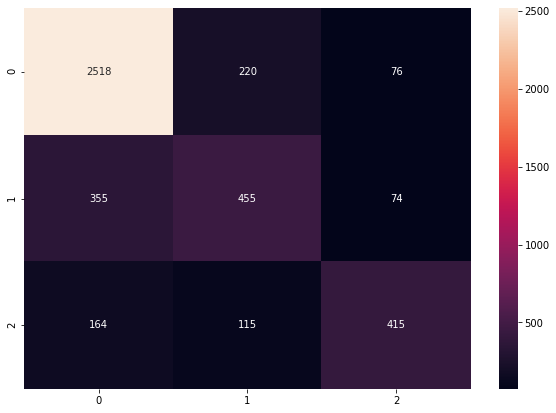

In [78]:
# Printing and Plotting Confusion matrix
conf_mat = confusion_matrix(y_test, result)
print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in "012"],
                      columns = [i for i in "012"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

In [79]:
print("=== Classification Report ===")
print(classification_report(y_test, result))

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      2814
           1       0.58      0.51      0.54       884
           2       0.73      0.60      0.66       694

    accuracy                           0.77      4392
   macro avg       0.71      0.67      0.69      4392
weighted avg       0.76      0.77      0.77      4392



### Using TfidfVectorizer

In [80]:
# TfidfVectorizer
tfid_vectorizer = TfidfVectorizer(max_features = 1000)
train_data_tfid_features = tfid_vectorizer.fit_transform(tweets2["text"])
train_data_tfid_features = train_data_tfid_features.toarray()

In [81]:
print (train_data_tfid_features.shape)

(14640, 1000)


In [82]:
vocab_tfid = tfid_vectorizer.get_feature_names()
print (vocab_tfid)

['aa', 'able', 'absolute', 'absolutely', 'accept', 'acceptable', 'access', 'accommodate', 'account', 'act', 'actual', 'actually', 'add', 'additional', 'address', 'advise', 'advisory', 'afternoon', 'agent', 'agents', 'ago', 'ahead', 'air', 'aircraft', 'airline', 'airlines', 'airplane', 'airport', 'airports', 'airways', 'alert', 'allow', 'almost', 'alone', 'along', 'already', 'also', 'always', 'amaze', 'america', 'american', 'americanair', 'americanairlines', 'amount', 'angry', 'announce', 'annoy', 'another', 'answer', 'anymore', 'anyone', 'anything', 'anyway', 'anywhere', 'apologies', 'apologize', 'apology', 'app', 'apparently', 'appear', 'appease', 'apply', 'appreciate', 'area', 'around', 'arrival', 'arrive', 'ask', 'assign', 'assist', 'assistance', 'atl', 'atlanta', 'attempt', 'attendant', 'attendants', 'attitude', 'austin', 'auto', 'automate', 'available', 'avgeek', 'avoid', 'award', 'away', 'awesome', 'awful', 'baby', 'back', 'bad', 'badcustomerservice', 'badservice', 'bag', 'baggag

In [83]:
XTD_train, XTD_test, ytd_train, ytd_test = train_test_split(train_data_tfid_features, tweets2["airline_sentiment"], test_size=0.3, random_state=42)

In [84]:
# Initialize a Random Forest classifier with 100 trees
forest2 = RandomForestClassifier(verbose=2,n_jobs=8,n_estimators = 100) 
# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
#
# This may take a few minutes to run
print ("Training the random forest...")
forest2 = forest2.fit(XTD_train, ytd_train)
# random forest performance through cross vaidation 
print (forest2)
print (np.mean(cross_val_score(forest2,train_data_tfid_features,tweets2["airline_sentiment"],cv=10)))

Training the random forest...
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100building tree 12 of 100

building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.7s


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78

[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    8.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=8,
                       oob_score=False, random_state=None, verbose=2,
                       warm_start=False)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    6.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   23.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    6.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   22.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    6.7s
[Parallel(n_jobs=8)]: Done 100

0.7287568306010929


In [85]:
# Predict the result for test data using the model built above.

result2 = forest2.predict(XTD_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished


[[2630  134   50]
 [ 424  399   61]
 [ 209   96  389]]


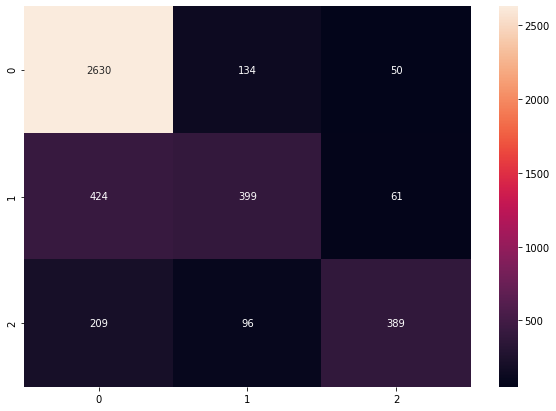

In [86]:
# Printing and Plotting Confusion matrix

conf_mat2 = confusion_matrix(ytd_test, result2)
print(conf_mat2)

df_cm2 = pd.DataFrame(conf_mat2, index = [i for i in "012"],
                      columns = [i for i in "012"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm2, annot=True, fmt='g')

In [87]:
print("=== Classification Report ===")
print(classification_report(ytd_test, result2))

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.81      0.93      0.87      2814
           1       0.63      0.45      0.53       884
           2       0.78      0.56      0.65       694

    accuracy                           0.78      4392
   macro avg       0.74      0.65      0.68      4392
weighted avg       0.77      0.78      0.76      4392



### Summary


    Dataset has reviews in alpha-numeric and text format with HTML tags, sentiment score is on the scale of 0 to 2, with '0' being 'negative','1' being 'neutral' and '2' being positive
    Pre-processing was done to remove HTML tags, numbers, special characters, converted to lower case, to remove contractions and then lemmatizing was performed.
    Random Forest model was build on the dataset ( with CountVectorizer and TdifVectorizer)
    Ramdom Forest with ContVectorizer has slightly better accuracy than RF with TfidVectorizer.




